In [ ]:
# 🌍 The Autonomous Colony - Environment Foundation

## Part 1: Custom Gymnasium Environment

This notebook builds a custom Gymnasium environment for multi-agent reinforcement learning.

### Key RL Concepts Covered:
- **MDP formulation** (States, Actions, Rewards, Transitions)
- **Partial observability** (POMDP)
- **Sparse rewards & reward shaping**
- **Resource management dynamics**
- **Multi-agent interaction space**

### Environment Features:
- 2D grid world with resources (food, water, materials)
- Multiple agents with energy/health systems
- Seasonal changes (dynamic rules)
- Partial observations (local vision)
- Emergent cooperation/competition

### Next Steps:
- Part 2: Tabular Q-learning agent
- Part 3: Deep RL (DQN, PPO)
- Part 4: Multi-agent coordination

## 📦 Setup - Install Dependencies

Uncomment the line below to install required packages (only needed on first run).

In [5]:
# Uncomment to install (first run only)
#!pip install gymnasium numpy matplotlib seaborn tensorboard wandb -q

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import gymnasium as gym
from gymnasium import spaces
from dataclasses import dataclass
from enum import IntEnum
import json

# Set style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Dependencies loaded")

✓ Dependencies loaded


## 🎯 Action & Resource Types

Define the discrete action space and resource types for the environment.

In [6]:
class ActionType(IntEnum):
    """Agent action space - 9 discrete actions"""
    MOVE_UP = 0
    MOVE_DOWN = 1
    MOVE_LEFT = 2
    MOVE_RIGHT = 3
    MOVE_UP_LEFT = 4
    MOVE_UP_RIGHT = 5
    MOVE_DOWN_LEFT = 6
    MOVE_DOWN_RIGHT = 7
    COLLECT = 8  # Collect resource at current position
    # Future: BUILD, COMMUNICATE, REST

class ResourceType(IntEnum):
    """Resources in the environment"""
    EMPTY = 0
    FOOD = 1
    WATER = 2
    MATERIAL = 3
    OBSTACLE = 4

print(f"✓ Action space: {len(ActionType)} actions")
print(f"✓ Resource types: {len(ResourceType)} types")

✓ Action space: 9 actions
✓ Resource types: 5 types


## 🤖 Agent State & Environment Configuration

Define the state representation for each agent and configurable hyperparameters.

In [7]:
@dataclass
class AgentState:
    """Individual agent state"""
    id: int
    x: int
    y: int
    energy: float = 100.0
    health: float = 100.0
    food_carried: int = 0
    water_carried: int = 0
    material_carried: int = 0
    steps_alive: int = 0

@dataclass
class EnvironmentConfig:
    """Environment hyperparameters"""
    grid_size: int = 20
    n_agents: int = 3
    max_steps: int = 500
    
    # Resource spawning
    food_spawn_rate: float = 0.02
    water_spawn_rate: float = 0.015
    material_spawn_rate: float = 0.01
    obstacle_density: float = 0.1
    
    # Agent parameters
    initial_energy: float = 100.0
    initial_health: float = 100.0
    energy_decay: float = 0.1  # Per step
    energy_from_food: float = 30.0
    health_from_water: float = 20.0
    
    # Observation
    observation_radius: int = 3  # 7x7 local view
    
    # Rewards
    reward_survive: float = 0.1
    reward_collect_food: float = 5.0
    reward_collect_water: float = 3.0
    reward_death_penalty: float = -50.0
    reward_low_energy: float = -1.0

print("✓ Agent and environment configuration defined")

✓ Agent and environment configuration defined


## 🏗️ Colony Environment - Class Definition

The main Gymnasium environment implementing the MDP:
- **State**: Partial observation (local grid view + internal agent state)
- **Action**: Discrete(9) - movement + collect
- **Reward**: Survival bonus, resource collection, penalties
- **Transition**: Grid dynamics, energy decay, resource spawning

In [8]:
class ColonyEnvironment(gym.Env):
    """
    Custom Gymnasium environment for The Autonomous Colony.
    
    Observation Space (per agent):
        - Local grid view: (2*r+1, 2*r+1, n_channels)
        - Internal state: [energy, health, food, water, material]
        
    Action Space:
        - Discrete(9): 8 directions + collect
        
    Reward:
        - Survival bonus per step
        - Resource collection rewards
        - Energy/health penalties
        - Death penalty
    """
    
    metadata = {'render_modes': ['human', 'rgb_array']}
    
    def __init__(self, config: EnvironmentConfig = None):
        super().__init__()
        self.config = config or EnvironmentConfig()
        
        # Grid: stores ResourceType values
        self.grid = np.zeros((self.config.grid_size, self.config.grid_size), dtype=np.int32)
        
        # Agents
        self.agents: List[AgentState] = []
        self.active_agents: List[bool] = []
        
        # Season system (for meta-RL later)
        self.season = 0  # 0=normal, 1=winter, 2=drought, etc.
        
        # Spaces
        obs_radius = self.config.observation_radius
        local_view_size = 2 * obs_radius + 1
        
        # Observation: local grid (one-hot encoded) + internal state
        self.observation_space = spaces.Dict({
            'grid': spaces.Box(
                low=0, high=1, 
                shape=(local_view_size, local_view_size, len(ResourceType)),
                dtype=np.float32
            ),
            'state': spaces.Box(
                low=0, high=np.inf,
                shape=(5,),  # energy, health, food, water, material
                dtype=np.float32
            )
        })
        
        self.action_space = spaces.Discrete(len(ActionType))
        
        self.current_step = 0
        self.episode_rewards = []
    
    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""
        super().reset(seed=seed)
        
        # Clear grid
        self.grid.fill(ResourceType.EMPTY)
        
        # Place obstacles
        n_obstacles = int(self.config.obstacle_density * self.grid.size)
        obstacle_positions = self.np_random.choice(
            self.grid.size, size=n_obstacles, replace=False
        )
        obstacle_coords = np.unravel_index(obstacle_positions, self.grid.shape)
        self.grid[obstacle_coords] = ResourceType.OBSTACLE
        
        # Spawn initial resources
        self._spawn_resources()
        
        # Initialize agents at random positions
        self.agents = []
        self.active_agents = []
        
        for i in range(self.config.n_agents):
            # Find empty position
            while True:
                x = self.np_random.integers(0, self.config.grid_size)
                y = self.np_random.integers(0, self.config.grid_size)
                if self.grid[y, x] == ResourceType.EMPTY and not self._position_occupied(x, y):
                    break
            
            agent = AgentState(
                id=i,
                x=x,
                y=y,
                energy=self.config.initial_energy,
                health=self.config.initial_health
            )
            self.agents.append(agent)
            self.active_agents.append(True)
        
        self.current_step = 0
        self.episode_rewards = [0.0] * self.config.n_agents
        
        # Return observations for all agents
        observations = [self._get_observation(i) for i in range(self.config.n_agents)]
        info = {'step': 0, 'active_agents': sum(self.active_agents)}
        
        return observations, info
    
    def step(self, actions: List[int]):
        """Execute one step with actions from all agents"""
        self.current_step += 1
        
        rewards = [0.0] * self.config.n_agents
        dones = [False] * self.config.n_agents
        truncated = [False] * self.config.n_agents
        
        # Process each agent's action
        for i, action in enumerate(actions):
            if not self.active_agents[i]:
                continue
                
            agent = self.agents[i]
            reward = 0.0
            
            # Execute action
            if action <= ActionType.MOVE_DOWN_RIGHT:
                reward += self._handle_move(agent, action)
            elif action == ActionType.COLLECT:
                reward += self._handle_collect(agent)
            
            # Energy decay
            agent.energy -= self.config.energy_decay
            
            # Survival bonus
            reward += self.config.reward_survive
            
            # Check energy/health
            if agent.energy < 20:
                reward += self.config.reward_low_energy
            
            if agent.energy <= 0 or agent.health <= 0:
                self.active_agents[i] = False
                dones[i] = True
                reward += self.config.reward_death_penalty
            
            agent.steps_alive += 1
            rewards[i] = reward
            self.episode_rewards[i] += reward
        
        # Spawn new resources
        if self.current_step % 10 == 0:
            self._spawn_resources()
        
        # Check episode termination
        episode_done = (self.current_step >= self.config.max_steps) or all(not a for a in self.active_agents)
        if episode_done:
            truncated = [True] * self.config.n_agents
        
        # Get observations
        observations = [self._get_observation(i) for i in range(self.config.n_agents)]
        
        info = {
            'step': self.current_step,
            'active_agents': sum(self.active_agents),
            'episode_rewards': self.episode_rewards.copy()
        }
        
        return observations, rewards, dones, truncated, info
    
    def _handle_move(self, agent: AgentState, action: int) -> float:
        """Handle movement action"""
        dx, dy = 0, 0
        
        if action == ActionType.MOVE_UP:
            dy = -1
        elif action == ActionType.MOVE_DOWN:
            dy = 1
        elif action == ActionType.MOVE_LEFT:
            dx = -1
        elif action == ActionType.MOVE_RIGHT:
            dx = 1
        elif action == ActionType.MOVE_UP_LEFT:
            dx, dy = -1, -1
        elif action == ActionType.MOVE_UP_RIGHT:
            dx, dy = 1, -1
        elif action == ActionType.MOVE_DOWN_LEFT:
            dx, dy = -1, 1
        elif action == ActionType.MOVE_DOWN_RIGHT:
            dx, dy = 1, 1
        
        new_x = np.clip(agent.x + dx, 0, self.config.grid_size - 1)
        new_y = np.clip(agent.y + dy, 0, self.config.grid_size - 1)
        
        # Check if position is valid
        if self.grid[new_y, new_x] != ResourceType.OBSTACLE and not self._position_occupied(new_x, new_y, exclude_agent=agent.id):
            agent.x = new_x
            agent.y = new_y
            return 0.0  # No penalty for valid move
        else:
            return -0.5  # Small penalty for invalid move
    
    def _handle_collect(self, agent: AgentState) -> float:
        """Handle resource collection"""
        resource = self.grid[agent.y, agent.x]
        
        if resource == ResourceType.FOOD:
            agent.food_carried += 1
            agent.energy = min(agent.energy + self.config.energy_from_food, 100.0)
            self.grid[agent.y, agent.x] = ResourceType.EMPTY
            return self.config.reward_collect_food
        
        elif resource == ResourceType.WATER:
            agent.water_carried += 1
            agent.health = min(agent.health + self.config.health_from_water, 100.0)
            self.grid[agent.y, agent.x] = ResourceType.EMPTY
            return self.config.reward_collect_water
        
        elif resource == ResourceType.MATERIAL:
            agent.material_carried += 1
            self.grid[agent.y, agent.x] = ResourceType.EMPTY
            return 1.0  # Small reward for materials
        
        return -0.1  # Penalty for collecting nothing
    
    def _get_observation(self, agent_id: int) -> Dict:
        """Get observation for a specific agent (POMDP - partial observability)"""
        agent = self.agents[agent_id]
        r = self.config.observation_radius
        
        # Extract local view
        y_min = max(0, agent.y - r)
        y_max = min(self.config.grid_size, agent.y + r + 1)
        x_min = max(0, agent.x - r)
        x_max = min(self.config.grid_size, agent.x + r + 1)
        
        local_grid = self.grid[y_min:y_max, x_min:x_max]
        
        # Pad if at edge
        pad_top = r - (agent.y - y_min)
        pad_bottom = r - (y_max - agent.y - 1)
        pad_left = r - (agent.x - x_min)
        pad_right = r - (x_max - agent.x - 1)
        
        local_grid = np.pad(local_grid, ((pad_top, pad_bottom), (pad_left, pad_right)), constant_values=ResourceType.OBSTACLE)
        
        # One-hot encode
        grid_one_hot = np.eye(len(ResourceType))[local_grid].astype(np.float32)
        
        # Internal state
        state = np.array([
            agent.energy / 100.0,
            agent.health / 100.0,
            agent.food_carried / 10.0,  # Normalize
            agent.water_carried / 10.0,
            agent.material_carried / 10.0
        ], dtype=np.float32)
        
        return {'grid': grid_one_hot, 'state': state}
    
    def _spawn_resources(self):
        """Spawn resources randomly"""
        empty_positions = np.argwhere(self.grid == ResourceType.EMPTY)
        
        if len(empty_positions) == 0:
            return
        
        # Food
        n_food = int(self.config.food_spawn_rate * len(empty_positions))
        if n_food > 0:
            food_indices = self.np_random.choice(len(empty_positions), size=min(n_food, len(empty_positions)), replace=False)
            for idx in food_indices:
                y, x = empty_positions[idx]
                self.grid[y, x] = ResourceType.FOOD
        
        # Water
        empty_positions = np.argwhere(self.grid == ResourceType.EMPTY)
        n_water = int(self.config.water_spawn_rate * len(empty_positions))
        if n_water > 0 and len(empty_positions) > 0:
            water_indices = self.np_random.choice(len(empty_positions), size=min(n_water, len(empty_positions)), replace=False)
            for idx in water_indices:
                y, x = empty_positions[idx]
                self.grid[y, x] = ResourceType.WATER
    
    def _position_occupied(self, x: int, y: int, exclude_agent: int = -1) -> bool:
        """Check if position is occupied by another agent"""
        for i, agent in enumerate(self.agents):
            if i != exclude_agent and self.active_agents[i]:
                if agent.x == x and agent.y == y:
                    return True
        return False
    
    def render(self):
        """Render the environment"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        
        # Grid visualization
        grid_vis = np.zeros((*self.grid.shape, 3))
        
        # Color mapping
        colors = {
            ResourceType.EMPTY: [0.1, 0.1, 0.1],
            ResourceType.FOOD: [0.2, 0.8, 0.2],
            ResourceType.WATER: [0.2, 0.5, 1.0],
            ResourceType.MATERIAL: [0.6, 0.4, 0.2],
            ResourceType.OBSTACLE: [0.3, 0.3, 0.3]
        }
        
        for resource_type, color in colors.items():
            mask = self.grid == resource_type
            grid_vis[mask] = color
        
        ax1.imshow(grid_vis)
        
        # Draw agents
        for i, agent in enumerate(self.agents):
            if self.active_agents[i]:
                color = plt.cm.Set1(i / len(self.agents))
                ax1.plot(agent.x, agent.y, 'o', markersize=15, color=color, markeredgecolor='white', markeredgewidth=2)
                ax1.text(agent.x, agent.y, str(i), ha='center', va='center', color='white', fontsize=10, fontweight='bold')
        
        ax1.set_title(f'Colony World (Step {self.current_step})', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Agent stats
        ax2.axis('off')
        stats_text = f"COLONY STATUS - Step {self.current_step}/{self.config.max_steps}\n\n"
        
        for i, agent in enumerate(self.agents):
            status = "ACTIVE" if self.active_agents[i] else "DEAD"
            stats_text += f"Agent {i} [{status}]\n"
            stats_text += f"  Position: ({agent.x}, {agent.y})\n"
            stats_text += f"  Energy: {agent.energy:.1f}/100\n"
            stats_text += f"  Health: {agent.health:.1f}/100\n"
            stats_text += f"  Food: {agent.food_carried}, Water: {agent.water_carried}\n"
            stats_text += f"  Reward: {self.episode_rewards[i]:.1f}\n\n"
        
        stats_text += f"\nActive Agents: {sum(self.active_agents)}/{len(self.agents)}"
        
        ax2.text(0.1, 0.9, stats_text, fontsize=11, verticalalignment='top', fontfamily='monospace')
        
        plt.tight_layout()
        plt.show()

print("✓ ColonyEnvironment class defined")

✓ ColonyEnvironment class defined


## 🧪 Testing & Demo

Let's create an environment and test it with random actions to verify everything works correctly.

In [9]:
print("="*80)
print("TESTING COLONY ENVIRONMENT")
print("="*80)

# Create environment
config = EnvironmentConfig(
    grid_size=15,
    n_agents=3,
    max_steps=100
)

env = ColonyEnvironment(config)
print(f"✓ Environment created: {config.grid_size}x{config.grid_size} grid, {config.n_agents} agents")

# Test reset
observations, info = env.reset(seed=42)
print(f"✓ Environment reset: {len(observations)} observations")
print(f"  Observation shape - Grid: {observations[0]['grid'].shape}, State: {observations[0]['state'].shape}")

TESTING COLONY ENVIRONMENT
✓ Environment created: 15x15 grid, 3 agents
✓ Environment reset: 3 observations
  Observation shape - Grid: (7, 7, 5), State: (5,)


### 🎮 Run Random Policy

Execute a random policy for 50 steps to see the environment in action.


🎮 Running random policy for 50 steps...


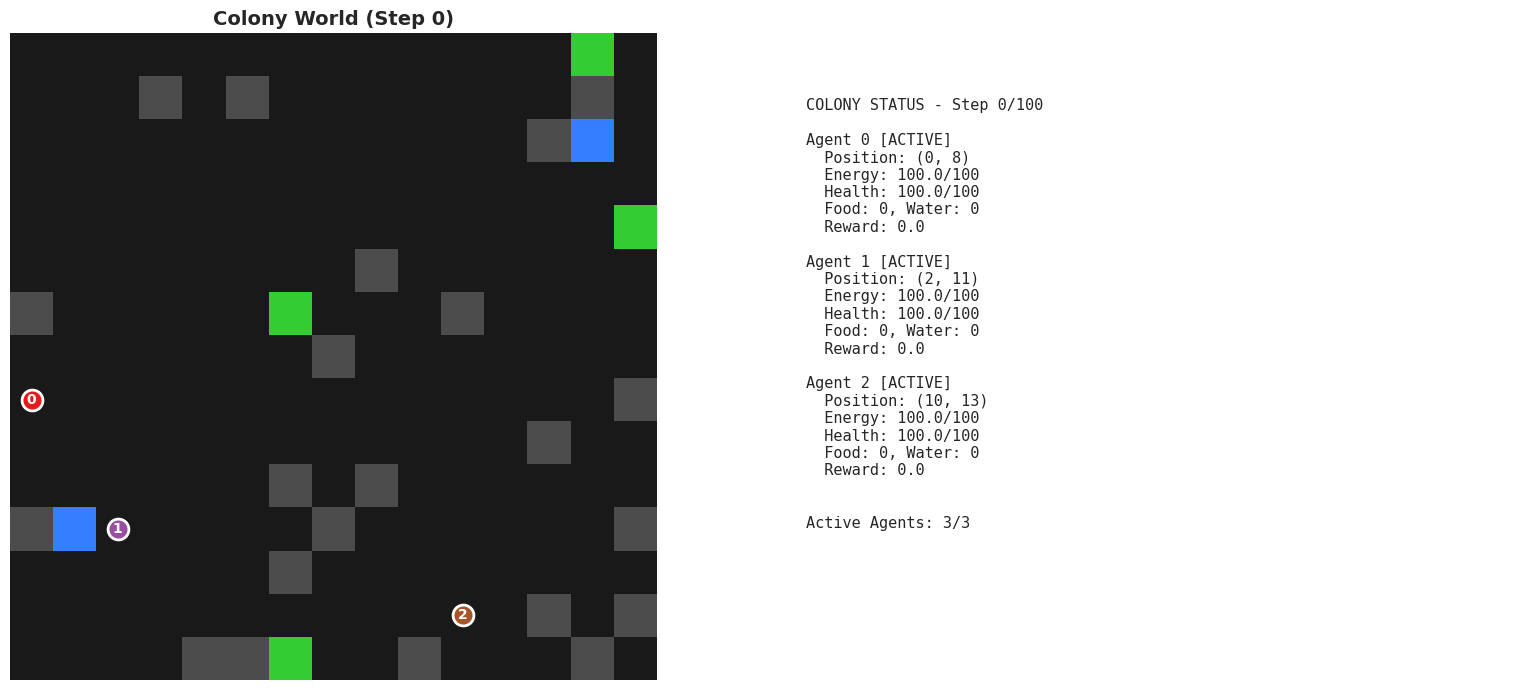


Step 0: Active agents = 3, Rewards = ['0.1', '0.1', '0.1']


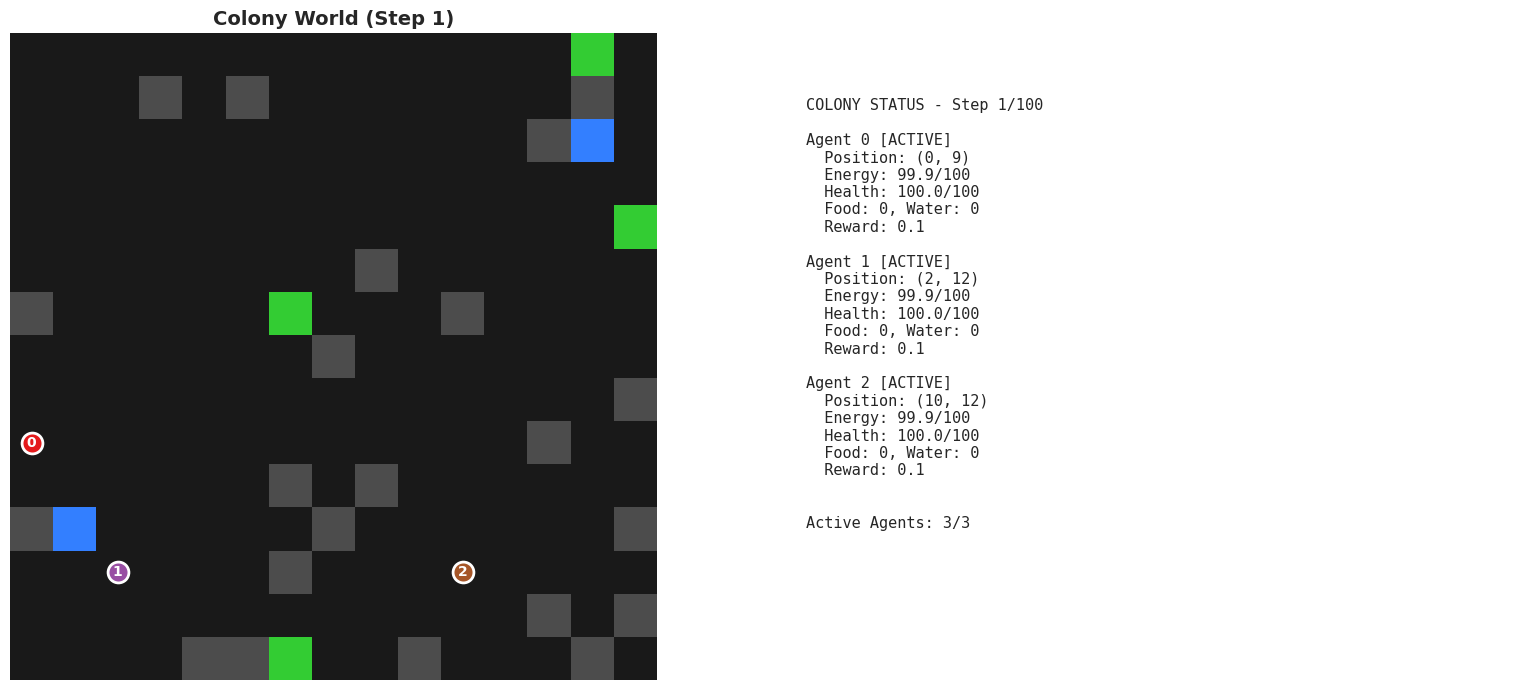


Step 20: Active agents = 3, Rewards = ['0.1', '0.1', '0.0']


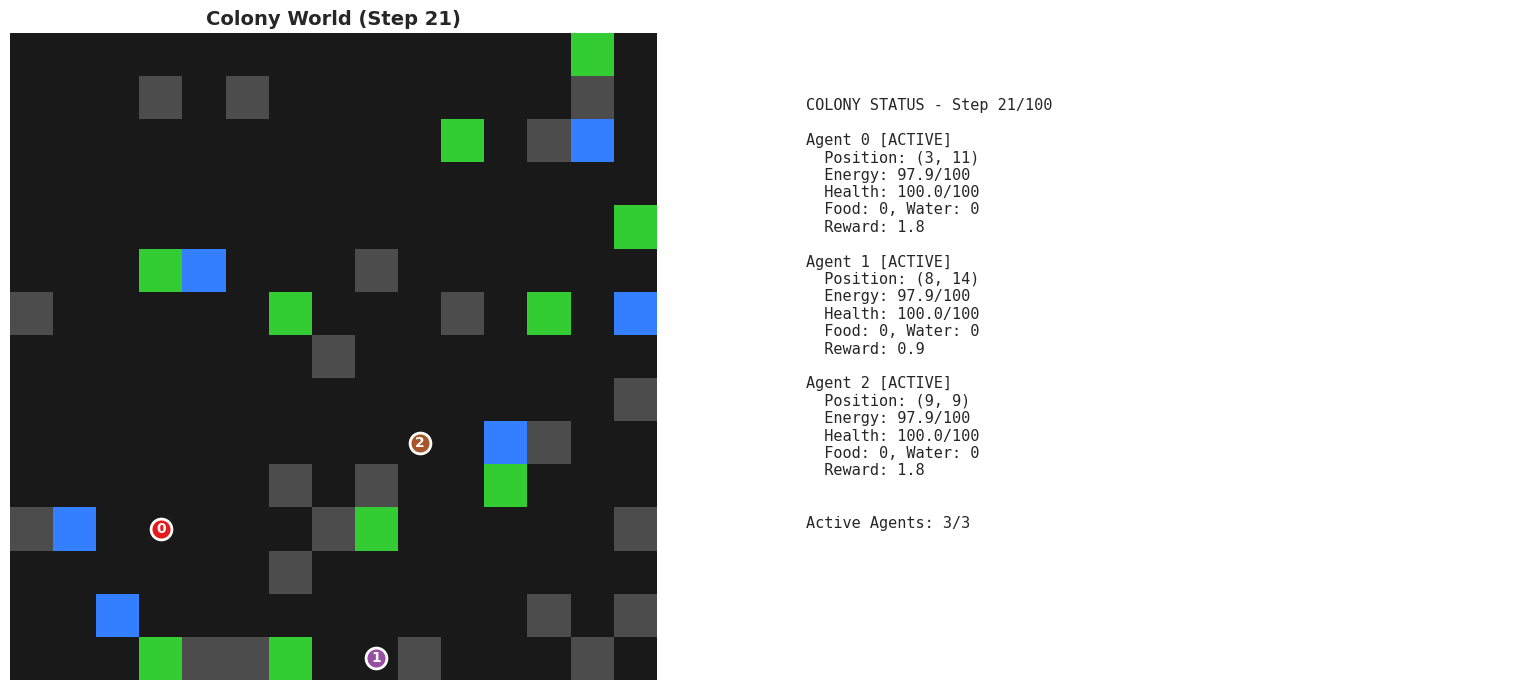


Step 40: Active agents = 3, Rewards = ['0.1', '-0.4', '0.1']


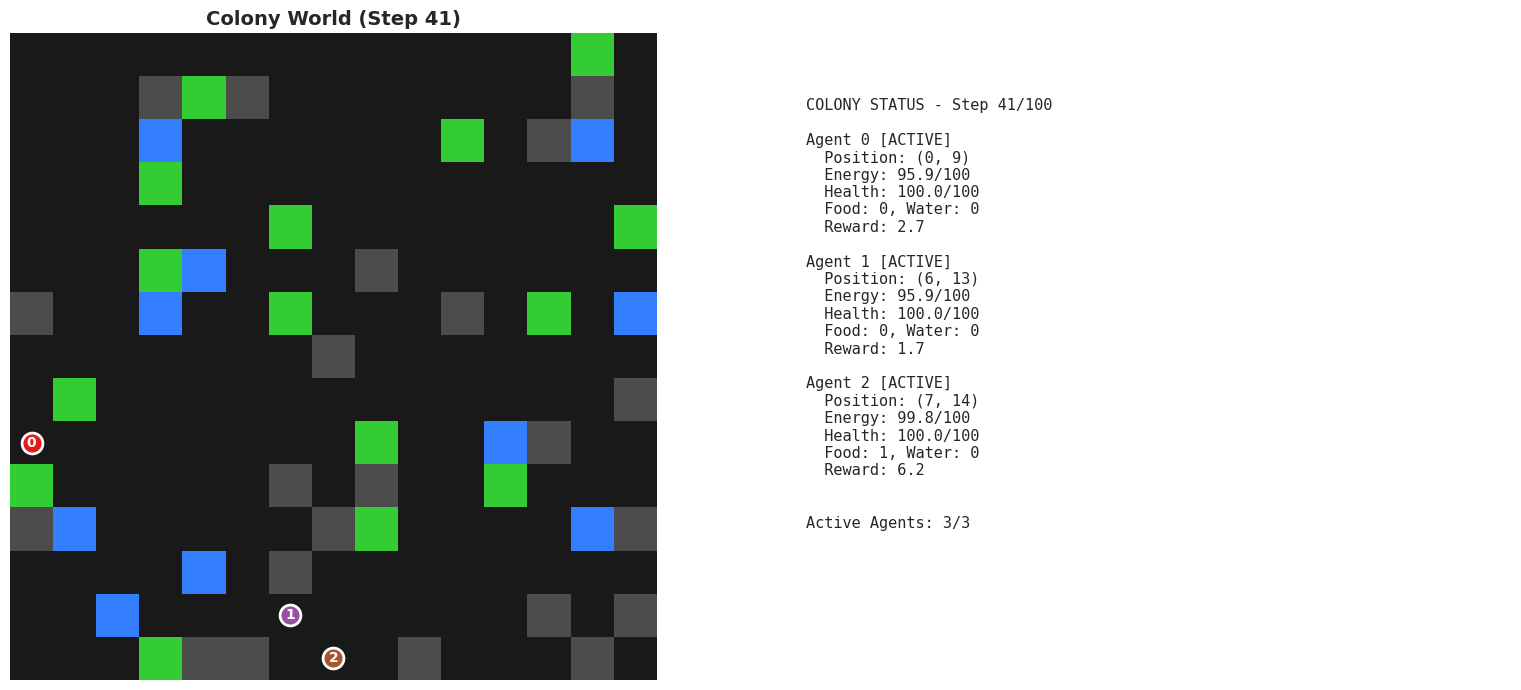


✓ Episode complete! Final rewards: [3.0000000000000027, 1.4000000000000017, 9.599999999999998]
  Survival times: [50, 50, 50]


In [10]:
print("\n🎮 Running random policy for 50 steps...")
env.render()

for step in range(50):
    # Random actions for all agents
    actions = [env.action_space.sample() for _ in range(config.n_agents)]
    observations, rewards, dones, truncated, info = env.step(actions)
    
    if step % 20 == 0:
        print(f"\nStep {step}: Active agents = {info['active_agents']}, Rewards = {[f'{r:.1f}' for r in rewards]}")
        env.render()
    
    if all(truncated):
        break

print(f"\n✓ Episode complete! Final rewards: {info['episode_rewards']}")
print(f"  Survival times: {[agent.steps_alive for agent in env.agents]}")

## ✅ Summary

**Environment Complete!** 

You've now built a custom Gymnasium environment with:
- ✓ Multi-agent support with partial observability (POMDP)
- ✓ Resource management dynamics (food, water, materials)
- ✓ Energy/health systems with survival mechanics
- ✓ Reward shaping for RL training
- ✓ Visualization capabilities

**Next Steps:**
- **Part 2**: Implement Tabular Q-learning agent
- **Part 3**: Deep RL with DQN and PPO
- **Part 4**: Multi-agent coordination and communication